In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/neha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

 Import Packages

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

Importing Lyrics data

In [5]:
# Import Dataset
df = pd.read_csv('')
df1.head()

,song,year,artist,genre,lyrics
0,the-downward-spiral,2007,discharge,Rock,Mother Dear Mother\nIt's Cold Tonight\nLike Ev...
1,lulu-s-back-in-town,2008,fats-waller,Jazz,"Gotta get my old tuxedo pressed, gotta sew a b..."
2,donde-quieras-yo-ire,2006,backstreet-boys,Pop,Al fin del mundo llegare\nLo que quieras you h...
3,falling-in-love,2007,don-williams,Country,"Falling In Love Again\nLove be gentle, love be..."
4,i-hate-u-i-love-you,2016,gnash,Rock,Feeling used\nBut I'm\nStill missing you\nAnd ...


In [6]:
# df = df1.head(10)

In [7]:
print(df.genre.unique())

['Rock' 'Jazz' 'Pop' 'Country' 'Not Available' 'Metal']


In [8]:
print(df.artist.unique())

['discharge' 'fats-waller' 'backstreet-boys' 'don-williams' 'gnash'
 'accept' 'ali-tatyana' 'bryan-ferry-roxy-music' 'from-autumn-to-ashes'
 'everly-brothers']


In [9]:
print(df.year.unique())

[2007 2008 2006 2016 2004]


 Remove newline characters

In [12]:
# Convert to list
# data = df.lyrics.values.tolist()

# data = [re.sub('[^a-zA-Z ]' ,'', str(sent)) for sent in data]

# pprint(data[:1])

['Mother Dear MotherIts Cold TonightLike Every OtherEvery Other NightBut I '
 'Never FeelFeel It AnywayIm Gonna Need SomethingSomething SoonI Can Feel '
 'ItFeel It BeginBut I Dont KnowHow Im Gonna PayIt Must Be AboutMid December '
 'Right NowAnd I Think Im AboutSeventeenIm Not Real SureHow Old I FeelI Lost '
 'My ThoughtsIn Some DreamOh Mother I DontKnow HowI Got Where I AmBut Ill Try '
 'To Explain AnyhowSee GraduallyYou Get Sucked InInto ItWithout Ever '
 'ReallyRealisingJust Whats HappeningAnd That Is WhenThe Downward Spiral '
 'BeginsAnyway Back To How It All StartedIt Started With DopeWhy Not After All '
 'It Was Just The Once I Told MyselfI Didnt Even Like It Very MuchBut The '
 'People I Was With All Did ItThen I Tried SpeedWhy Not After All It Was Just '
 'The Once I Told MyselfThe Next Thing I Knew I Was Doing A Couple Of Grams A '
 'WeekThen A Friend Introduced Me To Smack Chasing The DragonWhy Not After All '
 'It Was Just The Once I Told MyselfWhy Not After All It Wasnt Us

In [13]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data_words = list(sent_to_words(data))

# print(data_words[:1])

[['mother', 'dear', 'motherits', 'cold', 'tonightlike', 'every', 'otherevery', 'other', 'nightbut', 'never', 'feelfeel', 'it', 'anywayim', 'gonna', 'need', 'sooni', 'can', 'feel', 'itfeel', 'it', 'beginbut', 'dont', 'knowhow', 'im', 'gonna', 'payit', 'must', 'be', 'aboutmid', 'december', 'right', 'nowand', 'think', 'im', 'not', 'real', 'surehow', 'old', 'feeli', 'lost', 'my', 'thoughtsin', 'some', 'dreamoh', 'mother', 'dontknow', 'howi', 'got', 'where', 'ambut', 'ill', 'try', 'to', 'explain', 'anyhowsee', 'graduallyyou', 'get', 'sucked', 'ininto', 'itwithout', 'ever', 'whats', 'happeningand', 'that', 'is', 'whenthe', 'downward', 'spiral', 'beginsanyway', 'back', 'to', 'how', 'it', 'all', 'startedit', 'started', 'with', 'dopewhy', 'not', 'after', 'all', 'it', 'was', 'just', 'the', 'once', 'told', 'myselfi', 'didnt', 'even', 'like', 'it', 'very', 'muchbut', 'the', 'people', 'was', 'with', 'all', 'did', 'itthen', 'tried', 'speedwhy', 'not', 'after', 'all', 'it', 'was', 'just', 'the', 'onc

### Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(bigram_mod[data_words[0]])

['mother', 'dear', 'motherits', 'cold', 'tonightlike', 'every', 'otherevery', 'other', 'nightbut', 'never', 'feelfeel', 'it', 'anywayim', 'gonna', 'need', 'sooni', 'can', 'feel', 'itfeel', 'it', 'beginbut', 'dont', 'knowhow', 'im', 'gonna', 'payit', 'must', 'be', 'aboutmid', 'december', 'right', 'nowand', 'think', 'im', 'not', 'real', 'surehow', 'old', 'feeli', 'lost', 'my', 'thoughtsin', 'some', 'dreamoh', 'mother', 'dontknow', 'howi', 'got', 'where', 'ambut', 'ill', 'try', 'to', 'explain', 'anyhowsee', 'graduallyyou', 'get', 'sucked', 'ininto', 'itwithout', 'ever', 'whats', 'happeningand', 'that', 'is', 'whenthe', 'downward', 'spiral', 'beginsanyway', 'back', 'to', 'how', 'it', 'all', 'startedit', 'started', 'with', 'dopewhy', 'not', 'after', 'all', 'it', 'was', 'just', 'the', 'once', 'told', 'myselfi', 'didnt', 'even', 'like', 'it', 'very', 'muchbut', 'the', 'people', 'was', 'with', 'all', 'did', 'itthen', 'tried', 'speedwhy', 'not', 'after', 'all', 'it', 'was', 'just', 'the', 'once

### Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mother', 'dear', 'motherit', 'cold', 'tonightlike', 'otherevery', 'nightbut', 'never', 'feelfeel', 'anywayim', 'go', 'need', 'sooni', 'feel', 'itfeel', 'beginbut', 'do', 'not', 'knowhow', 'be', 'go', 'payit', 'must', 'aboutmid', 'december', 'right', 'nowand', 'think', 'be', 'real', 'surehow', 'old', 'feeli', 'lose', 'thoughtsin', 'dreamoh', 'mother', 'dontknow', 'howi', 'get', 'ambut', 'ill', 'try', 'explain', 'anyhowsee', 'graduallyyou', 'get', 'suck', 'ininto', 'itwithout', 'ever', 's', 'happeningand', 'downward', 'spiral', 'beginsanyway', 'back', 'startedit', 'start', 'dopewhy', 'tell', 'myselfi', 'do', 'not', 'even', 'like', 'muchbut', 'people', 'itthen', 'try', 'speedwhy', 'tell', 'myselfthe', 'next', 'thing', 'know', 'couple', 'gram', 'weekthen', 'friend', 'introduce', 'smack', 'chase', 'dragonwhy', 'tell', 'myselfwhy', 'be', 'not', 'use', 'needlethen', 'start', 'say', 'never']]


### Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [18]:
id2word[10]

'couple'

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aboutmid', 1),
  ('ambut', 1),
  ('anyhowsee', 1),
  ('anywayim', 1),
  ('back', 1),
  ('be', 3),
  ('beginbut', 1),
  ('beginsanyway', 1),
  ('chase', 1),
  ('cold', 1),
  ('couple', 1),
  ('dear', 1),
  ('december', 1),
  ('do', 2),
  ('dontknow', 1),
  ('dopewhy', 1),
  ('downward', 1),
  ('dragonwhy', 1),
  ('dreamoh', 1),
  ('even', 1),
  ('ever', 1),
  ('explain', 1),
  ('feel', 1),
  ('feelfeel', 1),
  ('feeli', 1),
  ('friend', 1),
  ('get', 2),
  ('go', 2),
  ('graduallyyou', 1),
  ('gram', 1),
  ('happeningand', 1),
  ('howi', 1),
  ('ill', 1),
  ('ininto', 1),
  ('introduce', 1),
  ('itfeel', 1),
  ('itthen', 1),
  ('itwithout', 1),
  ('know', 1),
  ('knowhow', 1),
  ('like', 1),
  ('lose', 1),
  ('mother', 2),
  ('motherit', 1),
  ('muchbut', 1),
  ('must', 1),
  ('myselfi', 1),
  ('myselfthe', 1),
  ('myselfwhy', 1),
  ('need', 1),
  ('needlethen', 1),
  ('never', 2),
  ('next', 1),
  ('nightbut', 1),
  ('not', 3),
  ('nowand', 1),
  ('old', 1),
  ('otherevery', 1),
  

### Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.003*"want" + 0.003*"que" + 0.002*"quiera" + 0.002*"yo" + 0.002*"famous" + '
  '0.002*"rocknroll" + 0.002*"dollar" + 0.002*"llegarelo" + 0.002*"record" + '
  '0.002*"be"'),
 (1,
  '0.004*"love" + 0.003*"que" + 0.003*"fall" + 0.003*"quiera" + 0.003*"not" + '
  '0.002*"fallin" + 0.002*"yo" + 0.002*"know" + 0.002*"there" + 0.002*"s"'),
 (2,
  '0.079*"want" + 0.040*"rocknroll" + 0.040*"famous" + 0.026*"be" + '
  '0.026*"record" + 0.026*"dollar" + 0.020*"not" + 0.020*"tell" + '
  '0.020*"harley" + 0.020*"place"'),
 (3,
  '0.039*"go" + 0.034*"come" + 0.028*"never" + 0.028*"be" + 0.023*"not" + '
  '0.023*"away" + 0.023*"say" + 0.023*"stand" + 0.023*"heart" + 0.023*"tear"'),
 (4,
  '0.003*"get" + 0.003*"be" + 0.002*"want" + 0.002*"not" + 0.002*"rocknroll" + '
  '0.002*"tell" + 0.002*"famous" + 0.002*"home" + 0.002*"lulus" + '
  '0.002*"back"'),
 (5,
  '0.029*"sit" + 0.029*"something" + 0.022*"back" + 0.021*"metricyou" + '
  '0.021*"bad" + 0.021*"careful" + 0.021*"street" + 0.021*"run"

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.737356491247813

Coherence Score:  0.7243141275215045


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/neha/anaconda3/envs/projectlab/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.154471 -0.062118       1        1  21.132719
10    -0.334648 -0.153389       2        1  15.360187
3      0.115941  0.006146       3        1  13.578619
2      0.019993 -0.065618       4        1  11.269720
5     -0.091111  0.305806       5        1  10.289701
17     0.122196 -0.068878       6        1   9.274593
19     0.081533 -0.022479       7        1   8.248555
18     0.075592 -0.026104       8        1   5.845137
16     0.025680  0.006993       9        1   4.779803
13    -0.015606  0.007661      10        1   0.021354
1     -0.017620  0.001679      11        1   0.021022
4     -0.013420  0.006624      12        1   0.020971
14    -0.009614  0.004969      13        1   0.020888
11    -0.017482  0.017964      14        1   0.020112
0     -0.020628  0.003014      15        1   0.020072
7     -0.013762  0.007715      16        1   0.019994
8     -0.014292  0.006689      17        1   0.019961
15    -0.015245  0.007867      18        1   0.018925
6     -0.015897  0.007689      19        1   0.018853
9     -0.016081  0.007771      20        1   0.018810, topic_info=    Category       Freq    Term      Total  loglift  logprob
160  Default  19.000000     que  19.000000  30.0000  30.0000
195  Default  21.000000    love  21.000000  29.0000  29.0000
296  Default  20.000000    want  20.000000  28.0000  28.0000
161  Default  11.000000  quiera  11.000000  27.0000  27.0000
434  Default   9.000000   angel   9.000000  26.0000  26.0000
..       ...        ...     ...        ...      ...      ...
203  Topic20   0.000412   alone   2.173402   0.0083  -6.2409
265  Topic20   0.000412   night   3.029416  -0.3238  -6.2410
283  Topic20   0.000412   still   3.030494  -0.3242  -6.2411
189  Topic20   0.000412    give   3.618612  -0.5018  -6.2412
240  Topic20   0.000412  herall   1.270998   0.5444  -6.2413

[1268 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
113       2  1.040346   absolutamente
448       5  0.845559       abusewhen
310       4  0.835477      accountant
311       4  0.835236  affairsmanager
175       8  0.922310          againi
...     ...       ...             ...
306       3  0.132483            youi
307       1  0.787112           youif
433       3  0.816786          youone
308       1  0.787537      yourealize
309       1  0.974949          youyou

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 11, 4, 3, 6, 18, 20, 19, 17, 14, 2, 5, 15, 12, 1, 8, 9, 16, 7, 10])

In [24]:
mallet_path = '/Users/neha/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('stand', 0.14285714285714285),
   ('betterpull', 0.08571428571428572),
   ('cry', 0.08571428571428572),
   ('youbaby', 0.05714285714285714),
   ('town', 0.02857142857142857),
   ('magazinewhen', 0.02857142857142857),
   ('pageantive', 0.02857142857142857),
   ('saywont', 0.02857142857142857),
   ('make', 0.02857142857142857),
   ('graduallyyou', 0.02857142857142857)]),
 (7,
  [('shiti', 0.1111111111111111),
   ('wallplatinum', 0.07407407407407407),
   ('meoh', 0.07407407407407407),
   ('trust', 0.037037037037037035),
   ('wanna', 0.037037037037037035),
   ('perdere', 0.037037037037037035),
   ('heartyou', 0.037037037037037035),
   ('porqueseh', 0.037037037037037035),
   ('howi', 0.037037037037037035),
   ('soand', 0.037037037037037035)]),
 (6,
  [('back', 0.2608695652173913),
   ('stop', 0.043478260869565216),
   ('friend', 0.043478260869565216),
   ('sonare', 0.043478260869565216),
   ('trace', 0.043478260869565216),
   ('payit', 0.043478260869565216),
   ('ancho', 0.04347826

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

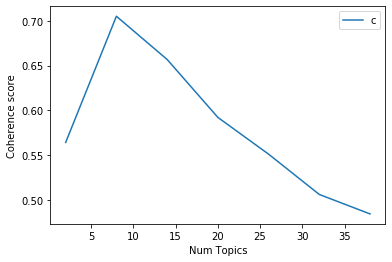

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5643
Num Topics = 8  has Coherence Value of 0.7051
Num Topics = 14  has Coherence Value of 0.6569
Num Topics = 20  has Coherence Value of 0.5923
Num Topics = 26  has Coherence Value of 0.5513
Num Topics = 32  has Coherence Value of 0.5063
Num Topics = 38  has Coherence Value of 0.4846


In [30]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.111*"uhhuhi" + 0.037*"saywont" + 0.037*"twois" + 0.037*"harmi" + '
  '0.037*"startwentyseven" + 0.037*"vestcause" + 0.037*"namei" + '
  '0.037*"wonderful" + 0.037*"make" + 0.037*"blow"'),
 (1,
  '0.085*"rocknroll" + 0.085*"famous" + 0.056*"dollar" + 0.056*"record" + '
  '0.042*"harley" + 0.042*"beverlywe" + 0.042*"place" + 0.042*"maserati" + '
  '0.042*"twentyfive" + 0.042*"golden"'),
 (2,
  '0.080*"mother" + 0.040*"nowand" + 0.040*"tape" + 0.040*"pride" + '
  '0.040*"graduallyyou" + 0.040*"tired" + 0.040*"ireeh" + 0.040*"whyit" + '
  '0.040*"sit" + 0.040*"feelfeel"'),
 (3,
  '0.128*"heart" + 0.106*"stand" + 0.085*"lonely" + 0.064*"trueim" + '
  '0.064*"youbut" + 0.064*"cry" + 0.043*"amissin" + 0.043*"againlove" + '
  '0.021*"leave" + 0.021*"knowi"'),
 (4,
  '0.118*"home" + 0.118*"tear" + 0.088*"hard" + 0.088*"fear" + 0.088*"sittin" '
  '+ 0.059*"youbaby" + 0.029*"wall" + 0.029*"busca" + 0.029*"insurance" + '
  '0.029*"makecause"'),
 (5,
  '0.121*"sit" + 0.091*"betterpull" + 

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1076,"give, habit, careful, watch, wallplatinum, aff...",Mother Dear MotherIts Cold TonightLike Every O...
1,1,16.0,0.1169,"fall, fallin, back, call, lulus, change, awayo...",Gotta get my old tuxedo pressed gotta sew a bu...
2,2,6.0,0.6476,"quiera, yo, amor, nena, sin, mundo, fin, llega...",Al fin del mundo llegareLo que quieras you har...
3,3,19.0,0.2572,"love, againid, youdont, inchorusfallin, kinda,...",Falling In Love AgainLove be gentle love be ki...
4,4,7.0,0.3117,"hate, miss, youi, herand, youyou, fuck, feelin...",Feeling usedBut ImStill missing youAnd I cantS...
5,5,1.0,0.4587,"rocknroll, famous, dollar, record, harley, bev...",Cruising in a limo down the sunset stripOn a S...
6,6,3.0,0.1943,"heart, stand, lonely, trueim, youbut, cry, ami...",Was I awake or was it just a dreamI opened up ...
7,7,18.0,0.4053,"angel, eye, eyesangel, shine, meoh, light, clo...",Oh angel eyes am I deceived or did you sighFor...
8,8,17.0,0.2930,"back, combatmy, electriclay, guttereasier, emb...",Less of a singer you are more more of a prosti...
9,9,8.0,0.2727,"kiss, yanever, yanow, live, amrich, yeahthing,...",Never felt like this until I kissed yaHow did ...


In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.4587,"rocknroll, famous, dollar, record, harley, bev...",Cruising in a limo down the sunset stripOn a S...
1,3.0,0.1943,"heart, stand, lonely, trueim, youbut, cry, ami...",Was I awake or was it just a dreamI opened up ...
2,6.0,0.6476,"quiera, yo, amor, nena, sin, mundo, fin, llega...",Al fin del mundo llegareLo que quieras you har...
3,7.0,0.3117,"hate, miss, youi, herand, youyou, fuck, feelin...",Feeling usedBut ImStill missing youAnd I cantS...
4,8.0,0.2727,"kiss, yanever, yanow, live, amrich, yeahthing,...",Never felt like this until I kissed yaHow did ...
